In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
import torch
from utils import utils
from torch.utils import data
from torch import nn
from models.classifierResnet import _C
from PIL import Image
import PIL
import skimage
import scipy
import re

In [99]:
torch.manual_seed(17)
plt.rcParams['figure.figsize'] = [9.0*1.5, 6.0*1.5]
available_device = "cuda" if torch.cuda.is_available() else "cpu"
C =_C(input_h_w=128)
C = C.to(available_device)
checkpoint = torch.load("models/multifrac_checkpoint_data_resnet/multifrac_cnn_vessels_model_476.pth")
C.load_state_dict(checkpoint)

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',transform=tfs.Compose([
                                                                            #tfs.RandomHorizontalFlip(p=0.7),
                                                                            #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                                            tfs.Resize((128, 128)),
                                                                            tfs.RandomRotation((0,360)),
                                                                            tfs.ToTensor()]))
                                                           

In [8]:
splits = utils.random_split(imagenet_data, (1000, len(imagenet_data.samples)-1000,))
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)
y_real_train, X_train, images = utils.iterations_test_partial_image(C, test_loader, available_device)
files_train = np.array(imagenet_data.imgs)[test_loader.dataset.indices][:, 0]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))

In [10]:
def select_file(img_n):
    replace_string = re.findall("\/*_frac_\w_\w*.png", img_n)
    if len(replace_string)==0:
        replace_string =".png"
    else:
        replace_string = replace_string[0]
    img_select = img_n.replace(replace_string, "")
    return img_select

In [101]:
def show(INDEX, merged_train, cant=5):
    
    fig_0 = plt.figure()
    
    img_n = merged_train.iloc[INDEX][0]
    score= X_train[INDEX]
    im = np.array(images[INDEX])#test_loader.dataset.__getitem__(INDEX)[0].cpu().numpy()
   
    ax = fig_0.add_subplot(131)
    ax.imshow(im[0].reshape(128, 128), cmap=plt.cm.gray)
    ax.set_title("INPUT NET")
    
    data_calc = pd.read_csv("data/result.csv",index_col =0)
    files = np.array(data_calc["image"])
    target = np.array(data_calc["target"])
    X_net = np.array(data_calc[data_calc.columns[:-2]])


    img_select = select_file(img_n)

    dist = []
    for j,i in enumerate(X_net):
        a = scipy.spatial.distance.euclidean(i, score)
        img_n_1 = files[j]
        img_n_1 = select_file(img_n_1)
        if a == 0 or img_select==img_n_1:
            #print(img_n_1, a)
            dist.append(100000000)
        else:
            dist.append(a)

  
    imgA = img_n
    replace_string_A = select_file(imgA)
    
    ax = fig_0.add_subplot(132)
    ax.imshow(skimage.io.imread(img_n.replace("full", "part"), 0))
    ax.set_title("ORIGINAL INPUT NET")
    
    ax = fig_0.add_subplot(133)
    ax.imshow(skimage.io.imread(imgA.replace("part", "full"), 0 ), alpha=0.6)
    ax.imshow(skimage.io.imread(replace_string_A + ".png", 0), alpha=0.3)
    class_n = re.findall(r'\d+', imgA)[0]
    ax.set_title("VESSEL TARGET -- CLASS {}".format(class_n))

    
    
    for imgB, dist_B in zip(files[np.argsort(dist)][0:cant], np.array(dist)[np.argsort(dist)[0:cant]]):
        fig_1 = plt.figure()
        #imgB = files[np.argmin(dist)]
        replace_string_B = select_file(imgB)
        ax = fig_1.add_subplot(121)
        ax.imshow(skimage.io.imread(imgB, 0))
        ax.set_title("FRAG -- {}".format(dist_B))
        
        ax = fig_1.add_subplot(122)
        ax.imshow(skimage.io.imread(imgB.replace("part","full"), 0 ), alpha=0.6)
        ax.imshow(skimage.io.imread(replace_string_B+".png", 0), alpha=0.3)
        class_n = re.findall(r'\d+', imgB)[0]
        ax.set_title("VESSEL -- CLASS {}".format(class_n))
    

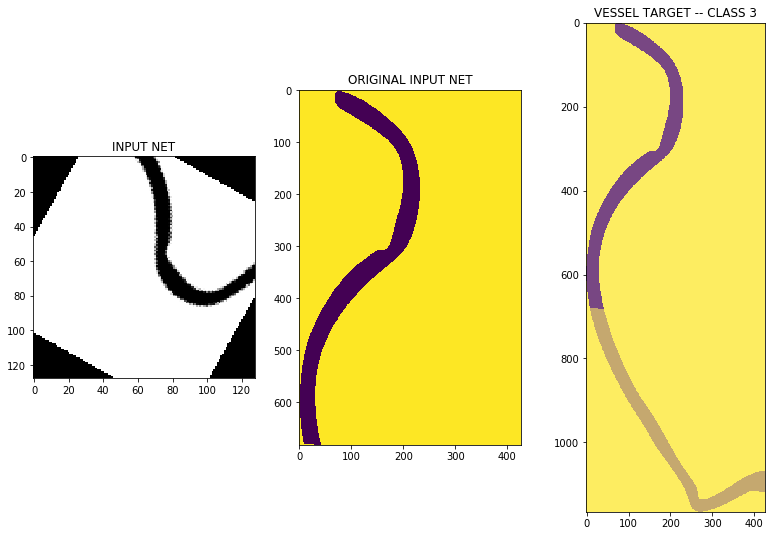

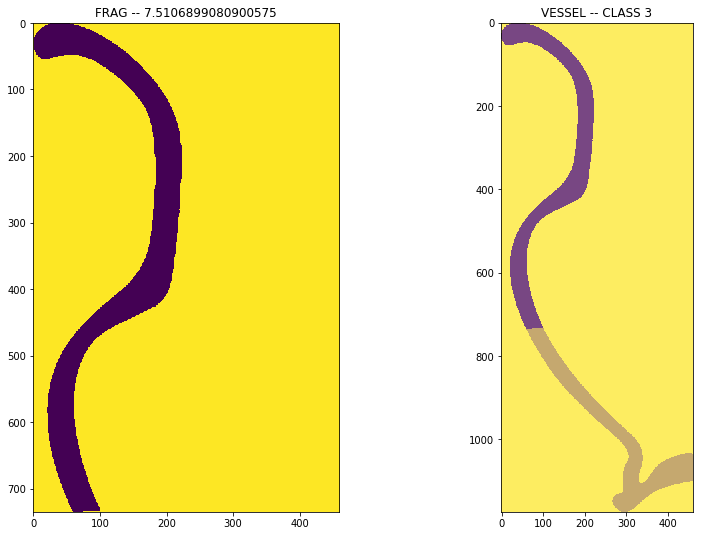

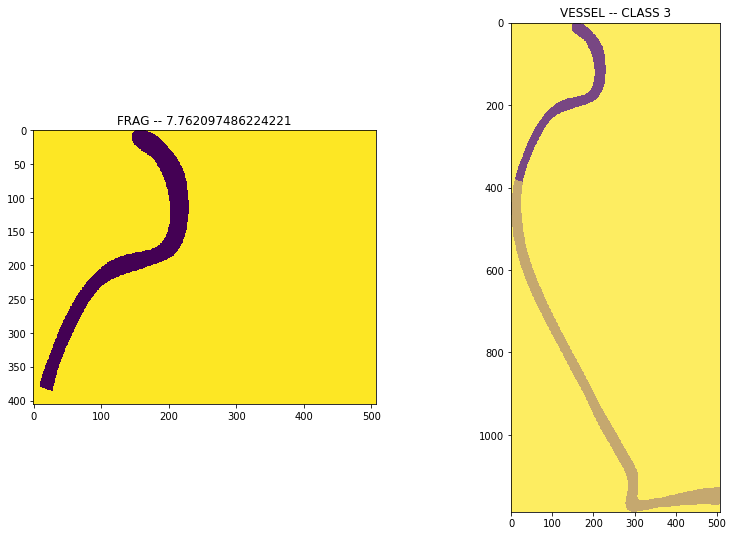

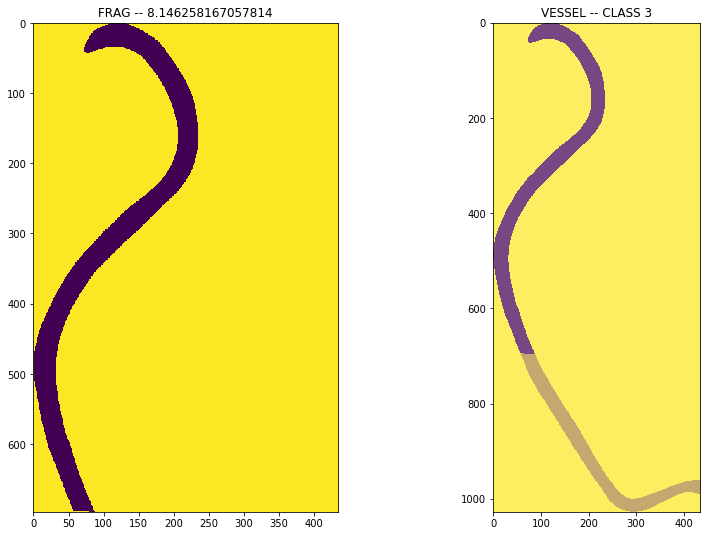

In [105]:
show(10, merged_train, cant=3)

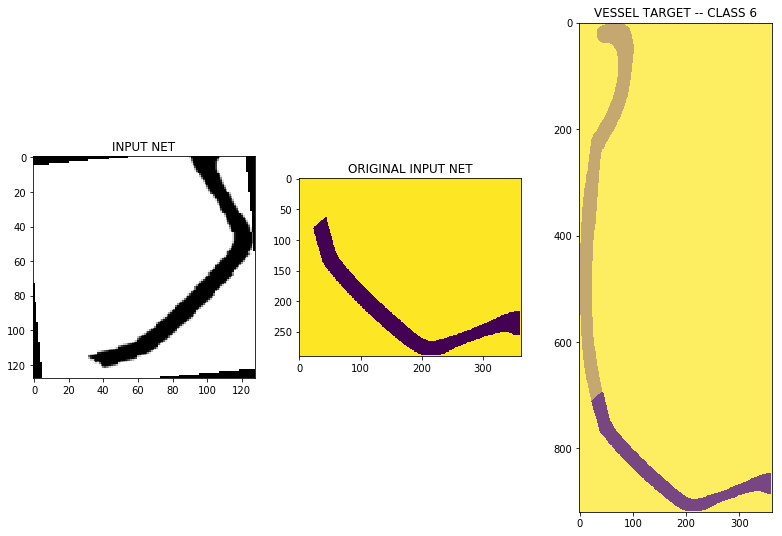

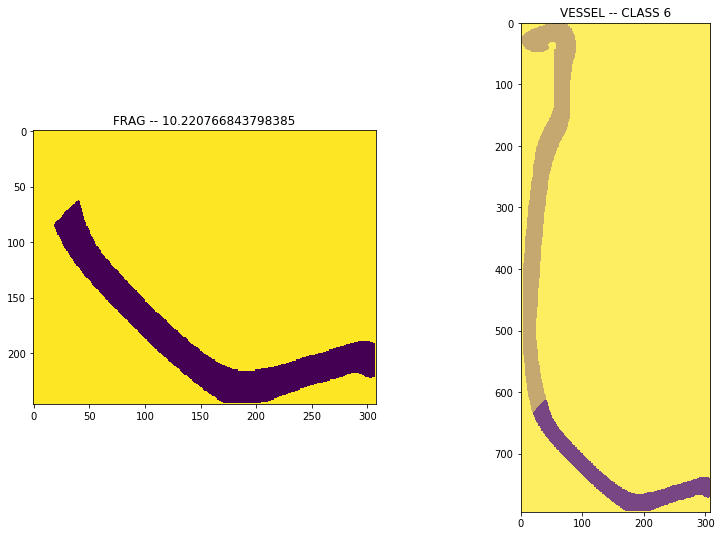

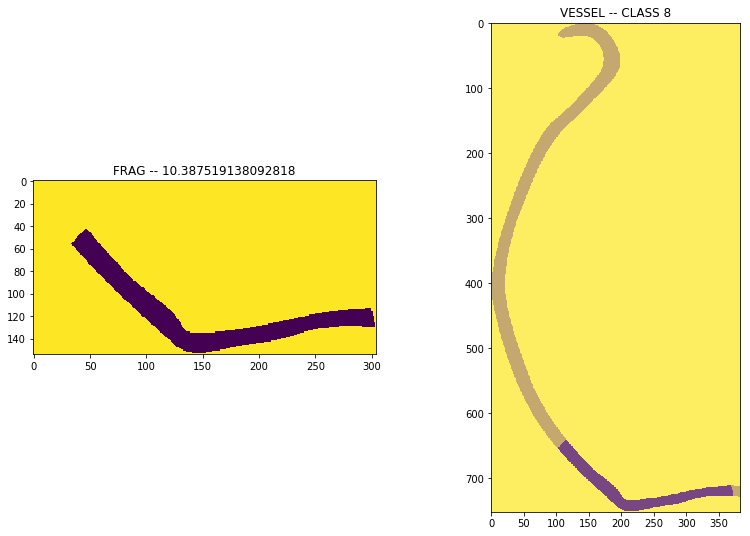

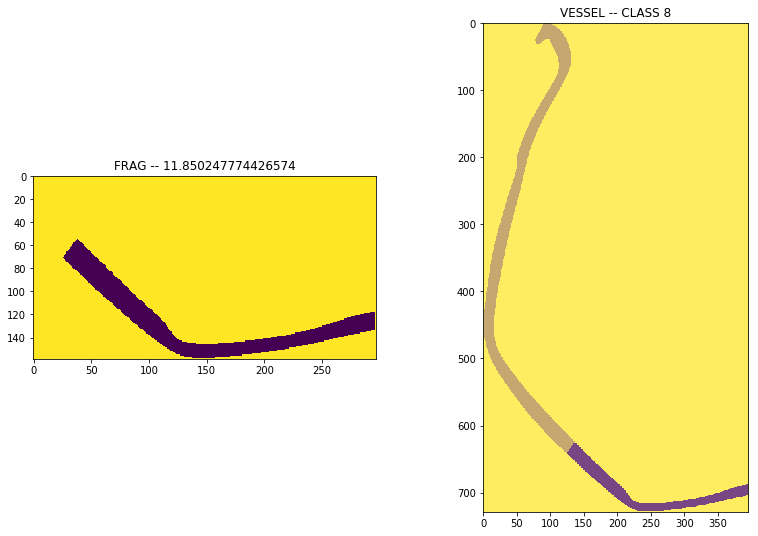

In [104]:
show(30, merged_train, cant=3)

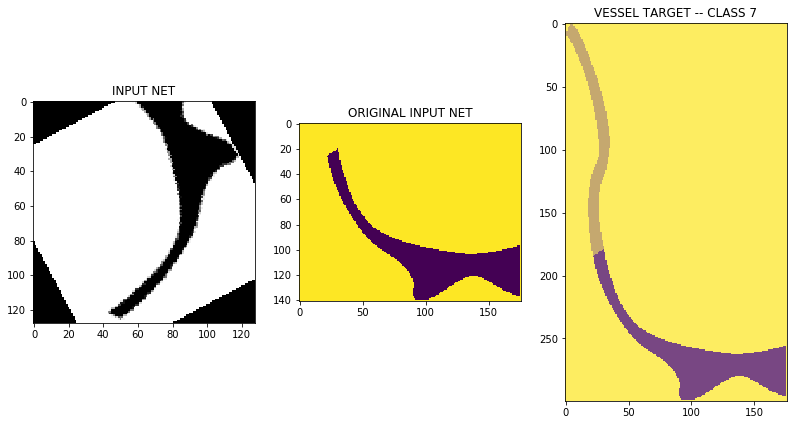

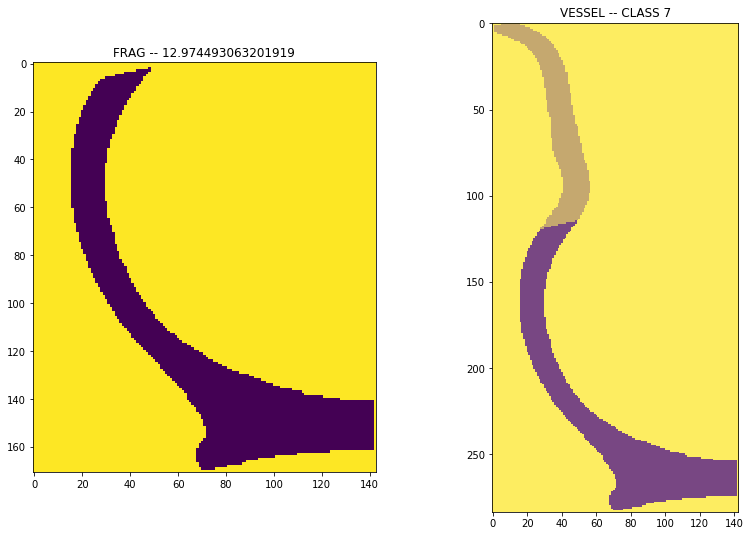

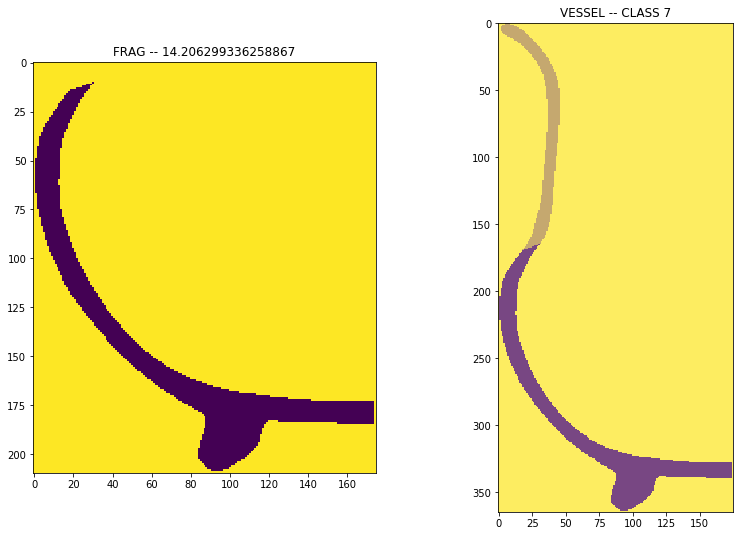

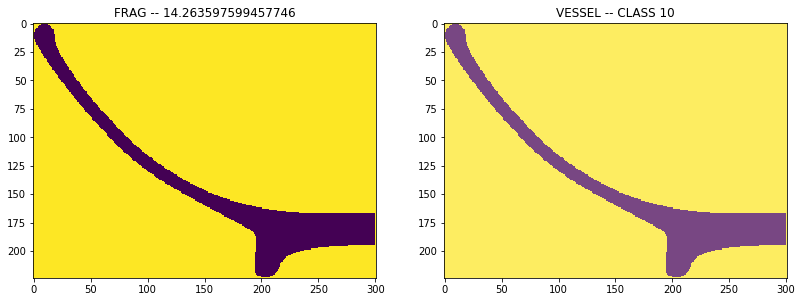

In [103]:
show(60, merged_train, cant=3)